# Regional Deterministic Prediction System (RDPS)

[webpage](http://weather.gc.ca/grib/grib2_reg_10km_e.html)

### Tasks
1. Download file from dd.weather.gc.ca
2. Use pygrib to open file
3. Visualize data with matplotlib basemap

In [326]:
% matplotlib notebook

import pygrib
import requests
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import datetime
import scipy.interpolate

import os

The data is found here: http://dd.weather.gc.ca/model_gem_regional/10km/grib2

In [327]:
url = "http://dd.weather.gc.ca/model_gem_regional/10km/grib2/HH/hhh"

From the documentation on RDPS we want to extract the wind velocity (U, V components) at 10 m.

    266	U Wind Component	10m above ground	UGRD_TGL_10m	metres per second
    267	V Wind Component	10m above ground	VGRD_TGL_10m	metres per second

We need to grab the most recent forecast output.  This is relative to the current time and date.

What are the four previous times... at 00, 06, 12, 18? 

  

In [328]:
# need to take 'datetime' mod '6 hours'
now = datetime.datetime.now()

# roll back to last hour...
lastrun = now - datetime.timedelta(hours=now.hour % 6, minutes=now.minute, 
                               seconds=now.second, microseconds=now.microsecond)
sixhours = datetime.timedelta(hours=6)

recentruns = [lastrun-i*sixhours for i in range(4)]

print (recentruns)

[datetime.datetime(2016, 10, 5, 12, 0), datetime.datetime(2016, 10, 5, 6, 0), datetime.datetime(2016, 10, 5, 0, 0), datetime.datetime(2016, 10, 4, 18, 0)]


In [329]:
d = { 'run_date' : recentruns[0].strftime('%Y%m%d'),
      'run_hour' : recentruns[0].hour,
      'forecast_hour' : 0,
      'variable' : 'VGRD_TGL_10',
    }

print(d)
filename = "CMC_reg_{variable}_ps10km_{run_date}{run_hour:02d}_P{forecast_hour:03d}.grib2".format(**d)
url = os.path.join("http://dd.weather.gc.ca/model_gem_regional/10km/grib2/{run_hour:02d}/{forecast_hour:03d}".format(**d),
                   filename)

{'forecast_hour': 0, 'run_hour': 12, 'run_date': '20161005', 'variable': 'VGRD_TGL_10'}


In [330]:
r = requests.get(url, stream=True)

Should check if the file was found, if not try the previous run ( -6 hours)

In [331]:
print(r.headers)

{'Via': '1.1 dd.weather.gc.ca', 'Date': 'Wed, 05 Oct 2016 18:54:24 GMT', 'Server': 'Apache', 'Last-Modified': 'Wed, 05 Oct 2016 14:48:59 GMT', 'Connection': 'Keep-Alive', 'Age': '1149', 'Content-Length': '490066', 'X-UA-Compatible': 'IE=Edge', 'Content-Type': 'application/octet-stream', 'Keep-Alive': 'timeout=5, max=100', 'Accept-Ranges': 'bytes'}


In [332]:
r.request.headers

{'User-Agent': 'python-requests/2.10.0', 'Accept': '*/*', 'Connection': 'keep-alive', 'Accept-Encoding': 'gzip, deflate'}

In [333]:
r.status_code

200

In [334]:
r.headers['content-type']

'application/octet-stream'

In [335]:
with open(filename, 'wb') as f:
    f.write(r.content)

In [336]:
# I could cache the file to disk if needed first...

In [337]:
grbs = pygrib.open(filename)

In [338]:
grbs.messages

1

In [339]:
grb = grbs[1]
print(grb)

1:10 metre V wind component:m s**-1 (instant):polar_stereographic:heightAboveGround:level 10 m:fcst time 0 hrs:from 201610051200


In [340]:
u = grb.values
lats, lons = grb.latlons()

In [341]:
print( 'min/max lat and lon',lats.min(), lats.max(), lons.min(), lons.max())

min/max lat and lon 17.3427261243 89.9561244127 -179.999767655 179.999920394


In [342]:
grb.analDate

datetime.datetime(2016, 10, 5, 12, 0)

In [343]:
grb.name

'10 metre V wind component'

In [344]:
grb.projparams

{'a': 6371229,
 'b': 6371229,
 'lat_0': 90.0,
 'lat_ts': 60.0,
 'lon_0': 249.0,
 'proj': 'stere'}

In [345]:
grb.keys()

['parametersVersion',
 'UseEcmfConventions',
 'GRIBEX_boustrophedonic',
 'hundred',
 'globalDomain',
 'GRIBEditionNumber',
 'grib2divider',
 'angularPrecision',
 'missingValue',
 'ieeeFloats',
 'isHindcast',
 'section0Length',
 'identifier',
 'discipline',
 'editionNumber',
 'totalLength',
 'sectionNumber',
 'section1Length',
 'numberOfSection',
 'centre',
 'centreDescription',
 'subCentre',
 'tablesVersion',
 'masterDir',
 'localTablesVersion',
 'significanceOfReferenceTime',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second',
 'dataDate',
 'julianDay',
 'dataTime',
 'productionStatusOfProcessedData',
 'typeOfProcessedData',
 'selectStepTemplateInterval',
 'selectStepTemplateInstant',
 'stepType',
 'setCalendarId',
 'deleteCalendarId',
 'is_uerra',
 'sectionNumber',
 'grib2LocalSectionPresent',
 'sectionNumber',
 'gridDescriptionSectionPresent',
 'section3Length',
 'numberOfSection',
 'sourceOfGridDefinition',
 'numberOfDataPoints',
 'numberOfOctectsForNumberOfPoints',
 'interpr

In [346]:
grb['orientationOfTheGridInDegrees']

249.0

<IPython.core.display.Javascript object>


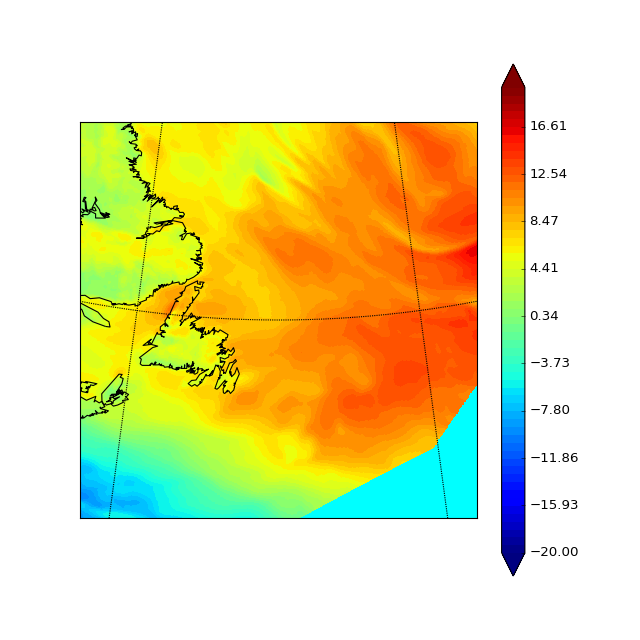

In [347]:
fig = plt.figure(figsize=(8,8))
m = Basemap(projection='lcc',
            lon_0=-50, lat_0=50, 
            height= 2000e3, width=2000e3,
            resolution='l')
m.drawcoastlines()
#m.fillcontinents(color='coral', lake_color='aqua')
# draw parallels and meridians
m.drawparallels(np.arange(-80.,81., 10.))
m.drawmeridians(np.arange(-180.,181., 20.))
m.drawmapboundary(fill_color='aqua')

x,y = m(lons,lats)
m.contourf(x,y,u, np.linspace(-20,20,60),extend='both')
plt.colorbar()

## Summary

These routine download the 10m wind data from the last four runs ('nowcasts') from RDPS.

In [348]:
datadir = 'data'
def download_file(urldir, filename):
    
    # create directory to store downloaded files
    if not os.path.exists('data'):
        os.mkdir(datadir)
        
    localfile = os.path.join(datadir, filename)
    # only download if we do not already have the file
    if not os.path.exists(localfile):
        url = os.path.join(urldir, filename)
    
        r = requests.get(url, stream=True)
        
        # resource found
        if r.status_code == 200:
            with open(localfile, 'wb') as f:
                f.write(r.content)
        else:
            # throw an exception?
            print('not found:', filename)
            return False
    else:
        print('cached file:', filename)
        
    return True

def get_lastrun():
    now = datetime.datetime.now()

    # go back three hours to give model a chance to upload the most recent data
    now = now - datetime.timedelta(hours=3)
    
    # need to take 'datetime' mod '6 hours'
    
    # roll back to last run (00, 06, 12, 18)...
    lastrun = now - datetime.timedelta(hours=now.hour % 6, minutes=now.minute, 
                               seconds=now.second, microseconds=now.microsecond)
    
    return lastrun

def download_wind_data():

    sixhours = datetime.timedelta(hours=6)

    lastrun = get_lastrun()
    recentruns = [lastrun-i*sixhours for i in range(5)]

    for recentrun in recentruns:
        for variable in ['UGRD_TGL_10', 'VGRD_TGL_10']:
            d = { 'run_date' : recentrun.strftime('%Y%m%d'),
                  'run_hour' : recentrun.hour,
                  'forecast_hour' : 0,
                  'variable' : variable,
            }

            filename = "CMC_reg_{variable}_ps10km_{run_date}{run_hour:02d}_P{forecast_hour:03d}.grib2".format(**d)
            urldir = "http://dd.weather.gc.ca/model_gem_regional/10km/grib2/{run_hour:02d}/{forecast_hour:03d}".format(**d)

            download_file(urldir, filename)
        
download_wind_data()

cached file: CMC_reg_UGRD_TGL_10_ps10km_2016100506_P000.grib2
cached file: CMC_reg_VGRD_TGL_10_ps10km_2016100506_P000.grib2
cached file: CMC_reg_UGRD_TGL_10_ps10km_2016100500_P000.grib2
cached file: CMC_reg_VGRD_TGL_10_ps10km_2016100500_P000.grib2
cached file: CMC_reg_UGRD_TGL_10_ps10km_2016100418_P000.grib2
cached file: CMC_reg_VGRD_TGL_10_ps10km_2016100418_P000.grib2
cached file: CMC_reg_UGRD_TGL_10_ps10km_2016100412_P000.grib2
cached file: CMC_reg_VGRD_TGL_10_ps10km_2016100412_P000.grib2


# Wind map

In [349]:
# so what do the winds look like?

# ensure they are already downloaded
download_wind_data()

lastrun = get_lastrun()

cached file: CMC_reg_UGRD_TGL_10_ps10km_2016100512_P000.grib2
cached file: CMC_reg_VGRD_TGL_10_ps10km_2016100512_P000.grib2
cached file: CMC_reg_UGRD_TGL_10_ps10km_2016100506_P000.grib2
cached file: CMC_reg_VGRD_TGL_10_ps10km_2016100506_P000.grib2
cached file: CMC_reg_UGRD_TGL_10_ps10km_2016100500_P000.grib2
cached file: CMC_reg_VGRD_TGL_10_ps10km_2016100500_P000.grib2
cached file: CMC_reg_UGRD_TGL_10_ps10km_2016100418_P000.grib2
cached file: CMC_reg_VGRD_TGL_10_ps10km_2016100418_P000.grib2
cached file: CMC_reg_UGRD_TGL_10_ps10km_2016100412_P000.grib2
cached file: CMC_reg_VGRD_TGL_10_ps10km_2016100412_P000.grib2


In [350]:
wind = {}

# load both u and v winds
for variable in ['UGRD_TGL_10', 'VGRD_TGL_10']:
    d = { 'run_date' : lastrun.strftime('%Y%m%d'),
          'run_hour' : lastrun.hour,
          'forecast_hour' : 0,
          'variable' : variable,
    }

    filename = "CMC_reg_{variable}_ps10km_{run_date}{run_hour:02d}_P{forecast_hour:03d}.grib2".format(**d)
    localfile = os.path.join(datadir, filename)
    print(localfile)
    
    grbs = pygrib.open(localfile)
    
    grb = grbs.readline()
    
    print(grb)
    
    wind[variable] = grb['values']
    lats, lons = grb.latlons()
    wind['lats'] = lats
    wind['lons'] = lons

    llcrnrlon = lons[0,0]
    llcrnrlat = lats[0,0]
    urcrnrlon = lons[-1,-1]
    urcrnrlat = lats[-1,-1]
    rsphere = (grb.projparams['a'], grb.projparams['b'])
    lat_ts = grb.projparams['lat_ts']
    lon_0 = grb.projparams['lon_0']
    lat_0 = grb.projparams['lat_0']
    projection = grb.projparams['proj']
    



data/CMC_reg_UGRD_TGL_10_ps10km_2016100512_P000.grib2
1:10 metre U wind component:m s**-1 (instant):polar_stereographic:heightAboveGround:level 10 m:fcst time 0 hrs:from 201610051200
data/CMC_reg_VGRD_TGL_10_ps10km_2016100512_P000.grib2
1:10 metre V wind component:m s**-1 (instant):polar_stereographic:heightAboveGround:level 10 m:fcst time 0 hrs:from 201610051200


In [351]:
import scipy.interpolate

<IPython.core.display.Javascript object>


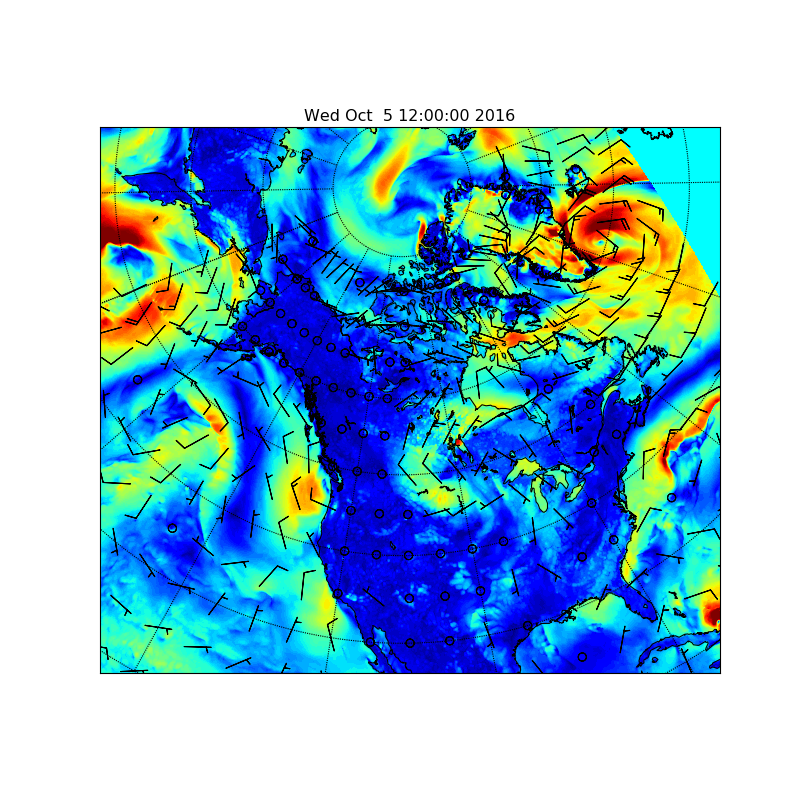

In [352]:
fig = plt.figure(figsize=(10,10))
m = Basemap(llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,
            urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat,rsphere=rsphere,lon_0=lon_0,
            lat_ts=lat_ts,lat_0=lat_0,resolution='l',projection=projection)

#m = Basemap(projection='npstere',
#            lon_0=-111, lat_0=50, 
#            boundinglat=50,
#            height= 2000e3, width=2000e3,
#            resolution='l')
m.drawcoastlines()
#m.fillcontinents(color='coral', lake_color='aqua')
# draw parallels and meridians
m.drawparallels(np.arange(-80.,81., 10.))
m.drawmeridians(np.arange(-180.,181., 20.))
m.drawmapboundary(fill_color='aqua')

u = wind['UGRD_TGL_10']
v = wind['VGRD_TGL_10']
wind_mag = np.sqrt(u**2 + v**2)

x,y = m(wind['lons'], wind['lats'])
m.contourf(x,y, wind_mag, np.linspace(0,20,60), extend='max')

# subsample grids onto lower resolution grid
# define grid (lons, lats)
lons, lats = np.mgrid[-180:0:5, 20:80:5]
xi, yi = m(lons, lats)

# grid the data.
ui = scipy.interpolate.griddata((x.flatten(), y.flatten()), u.flatten(), (xi, yi), method='nearest')
vi = scipy.interpolate.griddata((x.flatten(), y.flatten()), v.flatten(), (xi, yi), method='nearest')

#ui = scipy.interpolate.griddata((wind['lons'].flatten(), wind['lats'].flatten()), u.flatten(), (lons, lats), method='nearest')
#vi = scipy.interpolate.griddata((wind['lons'].flatten(), wind['lats'].flatten()), v.flatten(), (lons, lats), method='nearest')

m.barbs(lons, lats, ui, vi,  latlon=True, pivot='middle')
plt.title(lastrun.ctime())
#plt.colorbar()